In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import gaussian

import matplotlib.patches as mpatches
from skimage.measure import label, regionprops
from skimage.util import invert
from scipy.spatial.distance import euclidean

import numpy as np
from skimage.draw import polygon_perimeter
from commonfunctions import *

import cv2
import numpy as np
from commonfunctions import *

from skimage.measure import compare_ssim
import imutils
from imutils import contours
from skimage.segmentation import clear_border



In [47]:

alphabetics_dict = {}
Alpha_numeric_list=['A','B','C','D','E','F','G','H','I','G','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
                    '0','1','2','3','4','5','6','7','8','9',
                    'a','b','c','d','e','f','g','h','i','g','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

# import image
def read_image(image):
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    ret, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    return thresh

#read letters images and save their histograms
def readletters():
    for i in range(26):
        roi = read_image( 'alphanumeric/capital/' + Alpha_numeric_list[i] + '.png')
        roi=cv2.resize(roi,(36, 36))
        #show_images([roi],["roi"])
        alphabetics_dict.update( { Alpha_numeric_list[i] : roi } )
        
    for i in range(26,62):
        roi = read_image( "alphanumeric/" + Alpha_numeric_list[i] + ".png")
        roi=cv2.resize(roi,(36, 36))
        alphabetics_dict.update( { Alpha_numeric_list[i] : roi } )

    return

def rgbtogray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray
# cv2.imshow('threshold', thresh)

# dilation
def dilation(thresh):
    kernel = np.ones((10, 1), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)
    return img_dilation
# cv2.imshow('dilated', img_dilation)
    
# cv2.imshow('gray', gray)

# binary
def convert_to_binary(gray):
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    return ret,thresh

# find contours and sort them
def find_contours(img_dilation):
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    return sorted_ctrs





readletters() #save dictionary

#io.imshow(alphabetics_dict['A'])
# for key in alphabetics_dict:
#     #print(key)
#     show_images([alphabetics_dict[key]])



In [43]:
def CutInputLetters(image):
    # dilation
    kernel = np.ones((5, 5), np.uint8)
    img_dilation = cv2.dilate(image, kernel, iterations=1)


    # find contours

    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    # sort contours
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    
    rois = []
    locs = []
    for i, ctr in enumerate(sorted_ctrs):
        # Get bounding box
        x, y, w, h = cv2.boundingRect(ctr)

        # Getting ROI
        roi = image[y:y + h, x:x + w]
        if w > 15 and h > 15:
            cv2.imwrite('images//{}.png'.format(i), roi)
            #show_images([roi])
            rois.append(roi)
            locs.append((x, y, x+w, y + h))
    return rois, locs
def extract_digits_and_symbols(image, charCnts, minW=5, minH=15):
    
    # grab the internal Python iterator for the list of character
    # contours, then  initialize the character ROI and location
    # lists, respectively
    charIter = charCnts.__iter__()
    rois = []
    locs = []

    # keep looping over the character contours until we reach the end
    # of the list
    while True:
        try:
            c = next(charIter)
            (cX, cY, cW, cH) = cv2.boundingRect(c)
            roi = None

           # check to see if the width and height are sufficiently
           # large, indicating that we have found a digit
            if cW >= minW and cH >= minH:
               # extract the ROI   
                roi = image[cY:cY + cH, cX:cX + cW]
                rois.append(roi)
                locs.append((cX, cY, cX + cW, cY + cH))
                
        except StopIteration:
            break

    # return a tuple of the ROIs and locations
    return (rois, locs)

In [55]:



#image=read_image('images.png')
#image=read_image('abcd.jpg')
#image=read_image('alphabets - Copy.jpg')
#show_images([image])
image=cv2.imread('images.png')
# initialize a rectangular kernel (wider than it is tall) along with
# an empty list to store the output of the check OCR
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 7))
# convert the bottom image to grayscale, then apply a blackhat
# morphological operator to find dark regions against a light
# background (i.e., the routing and account numbers)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

# compute the Scharr gradient of the blackhat image, then scale
# the rest back into the range [0, 255]
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0,ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

# apply a closing operation using the rectangular kernel to help
# cloes gaps in between rounting and account digits, then apply
# Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# remove any pixels that are touching the borders of the image (this
# simply helps us in the next step when we prune contours)
thresh = clear_border(thresh)

# find contours in the thresholded image, then initialize the
# list of group locations
groupCnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
groupCnts = groupCnts[0] 

groupLocations=[] #will contain the digit locations
for i, ctr in enumerate(groupCnts):
    x, y, w, h = cv2.boundingRect(ctr)
        # only accept the contour region as a grouping of characters if
        # the ROI is sufficiently large
#         print("w "+str(w))
#         print("h "+str(h))
    if w > 50 and h > 15:
        groupLocations.append((x, y, w, h))
        
groupLocations = sorted(groupLocations, key=lambda x:x[0])       
#print(groupLocations)

output = []
# loop over the group locations
for (gX, gY, gW, gH) in groupLocations:
    # initialize the group output of characters
    groupOutput = []

    # extract the group ROI of characters from the grayscale
    # image, then apply thresholding to segment the digits from
    # the background of the credit card
    group = image[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    cv2.imshow("Group", group)
    cv2.waitKey(0)

    # find character contours in the group, then sort them from
    # left to right
    charCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    charCnts = imutils.grab_contours(charCnts)
    charCnts = contours.sort_contours(charCnts, method="left-to-right")[0]

    # find the characters and symbols in the group
    (rois, locs) = extract_digits_and_symbols(group, charCnts)
    delta=0
    # loop over the ROIs from the group
    for roi in rois:
        # initialize the list of template matching scores and
        # resize the ROI to a fixed size
        scores = []
        roi = cv2.resize(roi, (36, 36))

        # loop over the reference character name and corresponding
        # ROI
        for charName in Alpha_numeric_list:
            # apply correlation-based template matching, take the
            # score, and update the scores list
            result = cv2.matchTemplate(roi, alphabetics_dict[charName], cv2.TM_CCOEFF)
            
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)

        # the classification for the character ROI will be the
        # reference character name with the *largest* template
        # matching score
        groupOutput.append(Alpha_numeric_list[np.argmax(scores)])

    # draw (padded) bounding box surrounding the group along with
    # the OCR output of the group
    cv2.rectangle(image, (gX - 10, gY + delta - 10),
        (gX + gW + 10, gY + gY + delta), (0, 0, 255), 2)
    cv2.putText(image, "".join(groupOutput),
        (gX - 10, gY + delta - 25), cv2.FONT_HERSHEY_SIMPLEX,
        0.95, (0, 0, 255), 3)

    # add the group output to the overall check OCR output
    output.append("".join(groupOutput))

# display the output check OCR information to the screen
print("Check OCR: {}".format(" ".join(output)))
cv2.imshow("Check OCR", image)
cv2.waitKey(0)

error: OpenCV(4.1.1) C:\projects\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1527: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'cv::threshold'


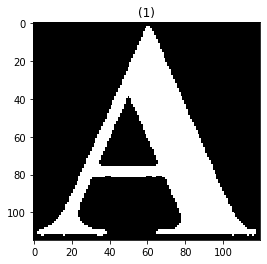

In [24]:

im = cv2.imread('alphanumeric/capital/A.png', cv2.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY_INV)
show_images([thresh])
